In [124]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import RobertaTokenizer, RobertaModel
from datasets import Dataset
import torch
import torch.nn as nn
from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')




In [4]:
import tarfile
import os

filepath = '/Volumes/KetanData/MELD.Raw.tar.gz'
extract_path = '/Volumes/KetanData/MELD_extracted'

os.makedirs(extract_path, exist_ok=True)

with tarfile.open(filepath, "r:gz") as tar:
    tar.extractall(path=extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /Volumes/KetanData/MELD_extracted


In [5]:
# Path to the compressed archive
tar_path = '/Volumes/KetanData/MELD_extracted/MELD.Raw/train.tar.gz'
extract_path = '/Volumes/KetanData/MELD_extracted/MELD.Raw/train/'

# Extract contents
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

Extraction complete.


In [89]:
# Path to CSVs
base_path = '/Volumes/KetanData/MELD_extracted/MELD.Raw/'
train_df = pd.read_csv(base_path + 'train/train_sent_emo.csv')
dev_df = pd.read_csv(base_path + 'dev_sent_emo.csv')
test_df = pd.read_csv(base_path + 'test_sent_emo.csv')

print(train_df.columns)
train_df.head()

Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [116]:
model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = tokenizer.model_max_length

def build_dynamic_context_inputs(df):
    inputs = []
    labels = []

    for dialog_id in df['Dialogue_ID'].unique():
        dialog = df[df['Dialogue_ID'] == dialog_id].sort_values('Utterance_ID')
        utterances = dialog['Utterance'].tolist()
        speakers = dialog['Speaker'].tolist()
        emotions = dialog['Emotion'].tolist()

        # Create speaker mapping for this dialogue
        unique_speakers = sorted(set(speakers))
        speaker_map = {name: f"speaker{i+1}" for i, name in enumerate(unique_speakers)}

        for idx in range(len(utterances)):
            context = []
            token_count = 0
            
            # Start from current utterance and go backward
            for i in range(idx, -1, -1):
                speaker_tag = speaker_map[speakers[i]]
                text_piece = f"{speaker_tag}: {utterances[i]}"
                tokens = tokenizer.tokenize(text_piece)
                token_count += len(tokens) + 1  # +1 for separator

                if token_count >= max_length:
                    break

                context.insert(0, text_piece)  # prepend so order is preserved

            input_text = " </s> ".join(context)
            inputs.append(input_text)
            labels.append(emotions[idx])

    return inputs, labels

train_inputs, train_labels = build_dynamic_context_inputs(train_df)
test_inputs, test_labels = build_dynamic_context_inputs(test_df)
dev_inputs, dev_labels = build_dynamic_context_inputs(dev_df)



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [117]:

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 2 layers of the encoder
for layer in model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Define classification head
class RobertaForEmotionClassification(nn.Module):
    def __init__(self, model, num_labels):
        super().__init__()
        self.roberta = model
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

# Instantiate model
num_labels = len(set(train_labels))  # e.g. 7 emotions
Full_model = RobertaForEmotionClassification(model, num_labels)


In [118]:

# Build new DataFrame from contextual inputs
label2id = {label: i for i, label in enumerate(sorted(set(train_labels)))} # Dict that maps each label to an integer
encoded_labels = [label2id[label] for label in train_labels]

# Now create the dataframe
data_dict = {
    "text": train_inputs,
    "label": encoded_labels
}
context_df = pd.DataFrame(data_dict)
dataset = Dataset.from_pandas(context_df)

# Function to tokenize the batch
def tokenize_batch(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True,
                     max_length=512,
                     return_attention_mask=True)

# Apply tokenizer
train_tokenized = dataset.map(tokenize_batch, batched=True, batch_size=32)

# Prepare for PyTorch
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Sanity check
print(train_tokenized[0].keys())


# Now for the test set
test_label2id = {label: i for i, label in enumerate(sorted(set(test_labels)))} # Dict that maps each label to an integer
test_encoded_labels = [test_label2id[label] for label in test_labels]
test_data_dict = {
    "text": test_inputs,
    "label": test_encoded_labels
}
context_df = pd.DataFrame(test_data_dict)
test_dataset = Dataset.from_pandas(context_df)
test_tokenized = test_dataset.map(tokenize_batch, batched=True, batch_size=32)
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# dev set
dev_label2id = {label: i for i, label in enumerate(sorted(set(dev_labels)))} # Dict that maps each label to an integer
dev_encoded_labels = [dev_label2id[label] for label in dev_labels]
dev_data_dict = {
    "text": dev_inputs,
    "label": dev_encoded_labels
}
context_df = pd.DataFrame(dev_data_dict)
dev_dataset = Dataset.from_pandas(context_df)
dev_tokenized = dev_dataset.map(tokenize_batch, batched=True, batch_size=32)
dev_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


# Create dataloaders for train and dev sets (and maybe also test set)
from torch.utils.data import DataLoader
train_loader = DataLoader(train_tokenized, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_tokenized, batch_size=16)
test_loader = DataLoader(test_tokenized, batch_size=16)

Map:   0%|          | 0/9989 [00:00<?, ? examples/s]

dict_keys(['label', 'input_ids', 'attention_mask'])


Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

In [120]:
# Prepare for training

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Full_model.to(device)
optimizer = torch.optim.AdamW(Full_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

from transformers import get_linear_schedule_with_warmup

# Total training steps = batches per epoch × number of epochs
epochs = 3
total_steps = len(train_loader) * epochs
warmup_steps = int(0.1 * total_steps)  # e.g., 10% warm-up

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)


In [123]:
all_train_batch_losses = []  # Store batch-wise training loss across epochs
all_val_batch_losses = []    # (Optional) for validation batch loss
all_learning_rates = []

for epoch in range(epochs):
    Full_model.train()
    train_loss = 0
    correct = 0
    total = 0
    epoch_batch_losses = []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = Full_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step() 
        current_lr = scheduler.get_last_lr()[0]
        all_learning_rates.append(current_lr)

        loss_value = loss.item()
        train_loss += loss_value
        epoch_batch_losses.append(loss_value)

        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    all_train_batch_losses.extend(epoch_batch_losses)

    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total
    print(f"\nTrain loss: {avg_loss:.4f} | Train accuracy: {accuracy:.4f}")

    # Validation loop
    Full_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    val_epoch_losses = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = Full_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_epoch_losses.append(loss.item())
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    all_val_batch_losses.extend(val_epoch_losses)

    avg_val_loss = val_loss / len(dev_loader)
    val_accuracy = correct / total
    print(f"Val loss: {avg_val_loss:.4f} | Val accuracy: {val_accuracy:.4f}")

Epoch 1 - Training:   0%|          | 0/625 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Load the trained model for F1 score
model_path = "/Volumes/KetanData/MELD_extracted/best_emotion_model_5.pt"
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

base_model = RobertaModel.from_pretrained("roberta-base")
Full_model = RobertaForEmotionClassification(base_model, num_labels)
Full_model.load_state_dict(checkpoint['model_state_dict'])
Full_model.eval()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForEmotionClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
          

In [129]:
from tqdm import tqdm

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = Full_model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

100%|██████████| 164/164 [08:13<00:00,  3.01s/it]


In [131]:
from sklearn.metrics import classification_report, f1_score

print("Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("Weighted F1:", f1_score(all_labels, all_preds, average='weighted'))
print("\nDetailed report:")
print(classification_report(all_labels, all_preds))

Macro F1: 0.43771940519920144
Weighted F1: 0.6406488201862905

Detailed report:
              precision    recall  f1-score   support

           0       0.55      0.46      0.50       345
           1       0.38      0.04      0.08        68
           2       0.20      0.06      0.09        50
           3       0.64      0.58      0.61       402
           4       0.73      0.86      0.79      1256
           5       0.45      0.35      0.39       208
           6       0.57      0.61      0.59       281

    accuracy                           0.66      2610
   macro avg       0.50      0.42      0.44      2610
weighted avg       0.64      0.66      0.64      2610



In [159]:
# Topic Modelling
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Full_model.to(device)
Full_model.eval()

all_embeddings = []

with torch.no_grad():
    for loader in [test_loader]:
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = Full_model.roberta(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeds = outputs.last_hidden_state[:, 0, :]  # CLS token

            all_embeddings.append(cls_embeds.cpu())

# Combine all embeddings safely
embeddings_np = torch.cat(all_embeddings, dim=0).numpy()


KeyboardInterrupt: 

2610

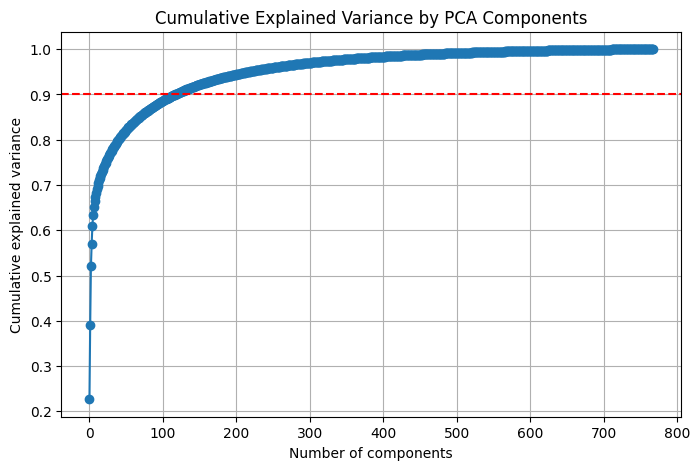

In [142]:
# Dimensionality reduction
pca = PCA().fit(embeddings_np)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(explained_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.show()



In [145]:

# Find number of components to retain 90% variance
n_components_90 = np.argmax(explained_variance >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components_90}")

# Apply PCA with the chosen number of components
pca_90 = PCA(n_components=n_components_90)
embeddings_reduced = pca_90.fit_transform(embeddings_np)

Number of components to retain 90% variance: 118


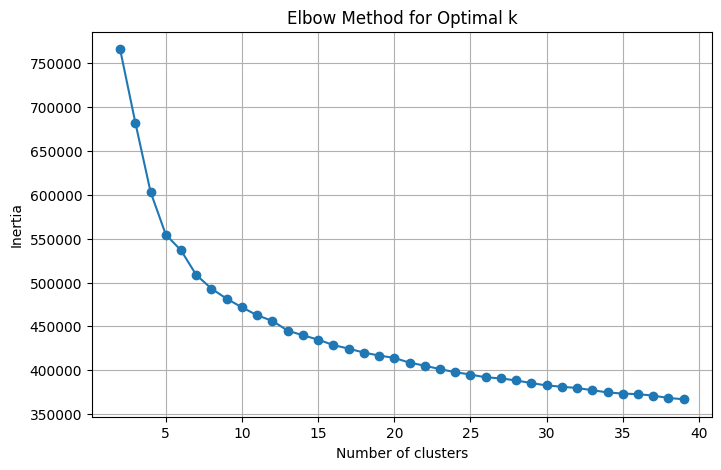

In [148]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(2, 40)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_reduced)  # use PCA-reduced embeddings
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

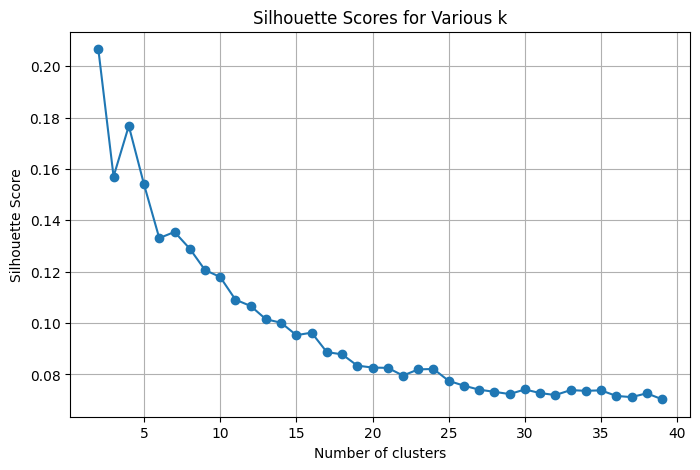

In [150]:
from sklearn.metrics import silhouette_score

scores = []
k_range = range(2, 40)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(embeddings_reduced)
    score = silhouette_score(embeddings_reduced, preds)
    scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, scores, marker='o')
plt.title("Silhouette Scores for Various k")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [156]:
best_k = 20  # for example
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(embeddings_reduced)

In [ ]:
# Now you need to assogn labels to clusters so that the topics are interpretable. 


In [ ]:
# For TSNE
from sklearn.manifold import TSNE

# Assume you've reduced to ~100 dims via PCA
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_reduced)

# Plot clusters
plt.figure(figsize=(8, 6))
for i in range(best_k):  # best_k from KMeans
    plt.scatter(embeddings_tsne[clusters == i, 0], embeddings_tsne[clusters == i, 1], label=f"Topic {i}")
plt.legend()
plt.title("t-SNE Visualization of Topic Clusters")
plt.grid(True)
plt.show()

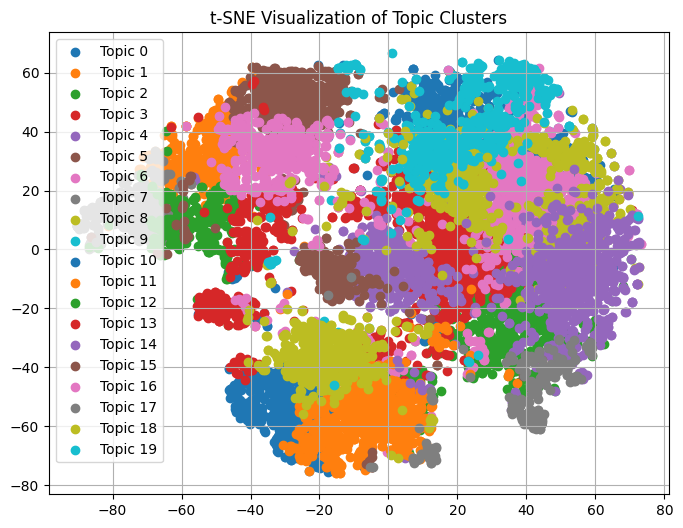

In [154]:
# Using UMAP for visualization
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Apply UMAP (assuming embeddings_reduced from PCA, e.g., 100 dims)
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
embeddings_umap = umap_model.fit_transform(embeddings_reduced)

# Plot clusters
plt.figure(figsize=(8, 6))
for i in range(best_k):  # `best_k` is the number of clusters (from KMeans)
    plt.scatter(embeddings_umap[clusters == i, 0], embeddings_umap[clusters == i, 1], label=f"Topic {i}")
plt.legend()
plt.title("UMAP Visualization of Topic Clusters")
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'umap.umap_'